# 4. Сверточные нейронные сети.

__Автор__: Никита Владимирович Блохин (NVBlokhin@fa.ru)

Финансовый университет, 2020 г.

In [278]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import seaborn as sns
from sklearn import metrics
from collections import OrderedDict

In [181]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [182]:
torch.set_warn_always(True)

plt.style.use("science")
sns.set_theme()

plt.rcParams["figure.figsize"] = (8, 4)

In [252]:
DATA_DIR = Path("data/")
MODELS_DIR = Path("models/")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cpu device


## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои. 
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [235]:
train_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

train_data.data.size(), train_data.targets.size(), len(train_data.classes)

(torch.Size([60000, 28, 28]), torch.Size([60000]), 10)

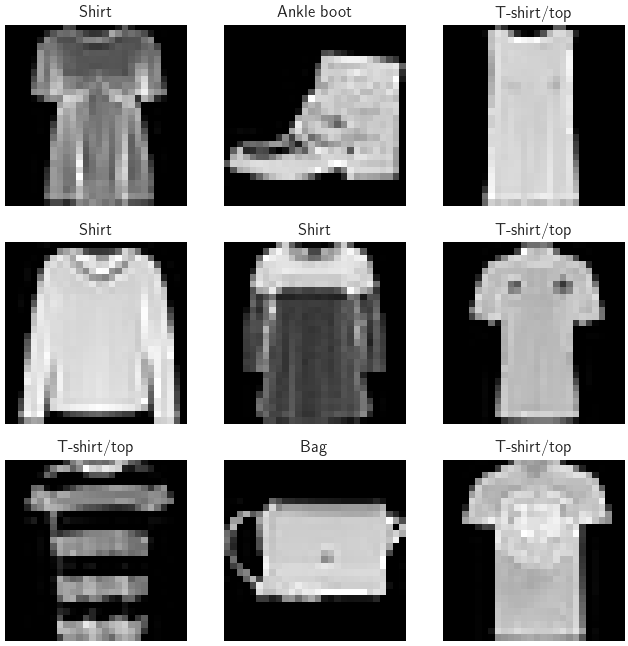

In [236]:
torch.manual_seed(0)

fig = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(train_data.classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

Архитектура модели взята из **[Introduction to PyTorch](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html#define-the-class)**:

In [162]:
class FashionMNISTLogisticRegression(nn.Module):

    def __init__(self, in_features: int, out_features: int):
        super(FashionMNISTLogisticRegression, self).__init__()
        self.flatten = nn.Flatten()  # по умолчанию разворачивает все измерения начиная с 1-ого
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_features),
        )

    def forward(self, x):
        x = self.flatten(x)  # (batch_size, n_channels * width * height)
        return self.classifier(x)

In [171]:
def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
) -> torch.Tensor:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)  # (batch_size, n_classes)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss
        if batch % 100 == 0:
            print(f"loss: {loss:>7f}  [{batch * len(X):>5d}/{size:>5d}]")

    return avg_loss / num_batches


def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
) -> tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:  # умеет работать с batch'ами; в нашем случае batch один
            pred = model(X)
            avg_loss += loss_fn(pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # noqa

    avg_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {accuracy:>4f}, Avg loss: {avg_loss:>8f} \n")

    return avg_loss, accuracy

Функция [потерь](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#loss-function) и [оптимизатор](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#optimizer) взяты из **Introduction to PyTorch**:

In [172]:
torch.manual_seed(0)

# количество входных параметров модели определяется как произведение:
# кол-во цветовых каналов * ширина картинки * высота картинки
net = FashionMNISTLogisticRegression(1 * 28 * 28, 10).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

train_dataloader = DataLoader(train_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=len(test_data))

net

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

Обучаем модели:

In [178]:
epochs = 10
train_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 32)
    train_loss = train_loop(train_dataloader, net, loss_fn, optimizer)
    train_losses.append(train_loss.item())
    test_loop(test_dataloader, net, loss_fn)  # смотрим на прогресс в реальном времени

Epoch 1
--------------------------------
loss: 0.669735  [    0/60000]
loss: 0.761546  [ 6400/60000]
loss: 0.530957  [12800/60000]
loss: 0.764309  [19200/60000]
loss: 0.698273  [25600/60000]
loss: 0.661099  [32000/60000]
loss: 0.733353  [38400/60000]
loss: 0.730378  [44800/60000]
loss: 0.726257  [51200/60000]
loss: 0.670002  [57600/60000]
Test Error: 
 Accuracy: 0.757900, Avg loss: 0.684956 

Epoch 2
--------------------------------
loss: 0.645185  [    0/60000]
loss: 0.739680  [ 6400/60000]
loss: 0.512141  [12800/60000]
loss: 0.749332  [19200/60000]
loss: 0.684935  [25600/60000]
loss: 0.647705  [32000/60000]
loss: 0.714931  [38400/60000]
loss: 0.719331  [44800/60000]
loss: 0.712496  [51200/60000]
loss: 0.655101  [57600/60000]
Test Error: 
 Accuracy: 0.766000, Avg loss: 0.669584 

Epoch 3
--------------------------------
loss: 0.622775  [    0/60000]
loss: 0.719328  [ 6400/60000]
loss: 0.495216  [12800/60000]
loss: 0.735585  [19200/60000]
loss: 0.672881  [25600/60000]
loss: 0.635873  [

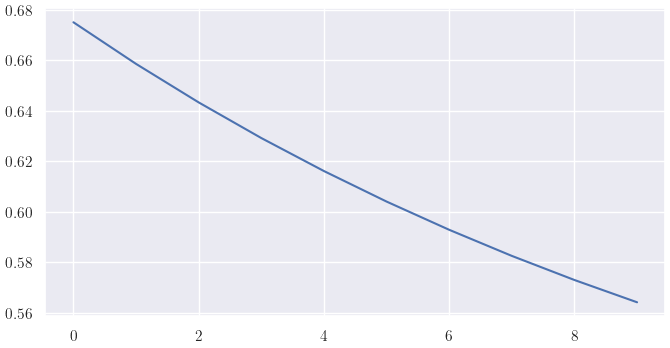

In [179]:
plt.plot(torch.arange(len(train_losses)), train_losses);

Пользуемся результатами обучения:

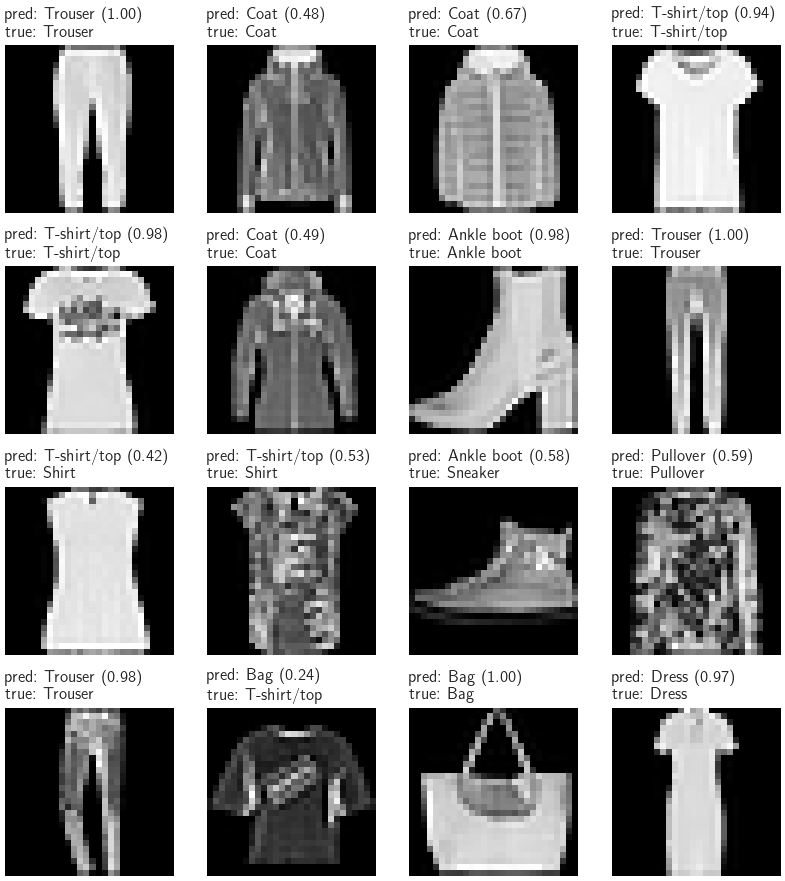

In [237]:
torch.manual_seed(0)
net.eval()

fig = plt.figure(figsize=(10, 11))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, true_label = test_data[sample_idx]

    pred = net(img.unsqueeze(0))
    pred_proba = F.softmax(pred, 1).max(1).values.item()  # насколько модель уверена в своем решении
    pred_label = pred.argmax(1).item()

    fig.add_subplot(rows, cols, i)
    plt.title(
        f"pred: {train_data.classes[pred_label]} ({pred_proba:.2f})"
        f"\ntrue: {train_data.classes[true_label]}", loc="left"
    )
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

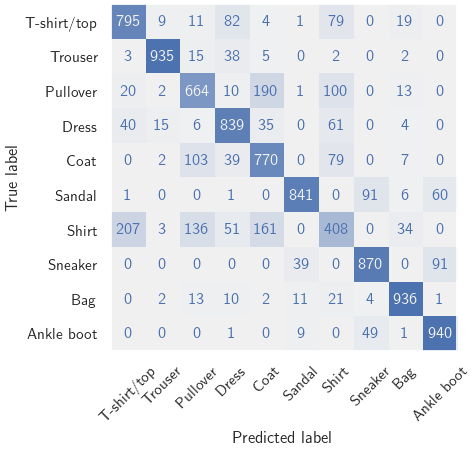

In [248]:
X_test, y_test = next(iter(test_dataloader))

pred = net(X_test)
pred_proba = torch.max(F.softmax(pred, dim=1), dim=1)
pred_label = pred.argmax(dim=1)

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, pred_label.detach(),
    display_labels=train_data.classes,
    xticks_rotation=45,
    cmap=sns.color_palette('light:b', as_cmap=True),
    colorbar=False,
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(4.5, 4.5)

In [255]:
test_loop(test_dataloader, net, loss_fn);

Test Error: 
 Accuracy: 0.799800, Avg loss: 0.582476 



Сохраняем модель:

In [267]:
torch.save(net, MODELS_DIR / "FashionMNIST-log-reg.pth")

In [268]:
net = torch.load(MODELS_DIR / "FashionMNIST-log-reg.pth")
net.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

Архитектура модели (вдохновлялся `models.vgg16`):

In [292]:
class FashionMNISTConvNet(nn.Module):

    def __init__(self, in_channels: int, n_classes: int):
        super(FashionMNISTConvNet, self).__init__()
        self.features = nn.Sequential(OrderedDict({  # noqa
            "conv1": nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=1, padding=1),
            "relu1": nn.ReLU(True),
            "maxpool1": nn.MaxPool2d(2),
            "conv2": nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
            "relu2": nn.ReLU(True),
            "maxpool2": nn.MaxPool2d(2),
        }))
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(OrderedDict({  # noqa
            "fc1": nn.Linear(64 * 6 * 6, 512),
            "relu1": nn.ReLU(True),
            "drop1": nn.Dropout(),
            "fc2": nn.Linear(512, n_classes),
        }))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [293]:
torch.manual_seed(0)

net = FashionMNISTConvNet(1, 10).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

train_dataloader = DataLoader(train_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=len(test_data))

net

FashionMNISTConvNet(
  (features): Sequential(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU(inplace=True)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=2304, out_features=512, bias=True)
    (relu1): ReLU(inplace=True)
    (drop1): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [294]:
epochs = 10
train_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 32)
    train_loss = train_loop(train_dataloader, net, loss_fn, optimizer)
    train_losses.append(train_loss.item())
    test_loop(test_dataloader, net, loss_fn)  # смотрим на прогресс в реальном времени

Epoch 1
--------------------------------
loss: 2.303182  [    0/60000]
loss: 2.304373  [ 6400/60000]
loss: 2.297578  [12800/60000]
loss: 2.291251  [19200/60000]
loss: 2.289475  [25600/60000]
loss: 2.275105  [32000/60000]
loss: 2.268246  [38400/60000]
loss: 2.258691  [44800/60000]
loss: 2.258757  [51200/60000]
loss: 2.247650  [57600/60000]
Test Error: 
 Accuracy: 0.275300, Avg loss: 2.241877 

Epoch 2
--------------------------------
loss: 2.248094  [    0/60000]
loss: 2.245771  [ 6400/60000]
loss: 2.220839  [12800/60000]
loss: 2.206512  [19200/60000]
loss: 2.192221  [25600/60000]
loss: 2.151072  [32000/60000]
loss: 2.156783  [38400/60000]
loss: 2.100266  [44800/60000]
loss: 2.063210  [51200/60000]
loss: 1.999463  [57600/60000]
Test Error: 
 Accuracy: 0.534700, Avg loss: 1.981835 

Epoch 3
--------------------------------
loss: 2.012598  [    0/60000]
loss: 1.944845  [ 6400/60000]
loss: 1.827874  [12800/60000]
loss: 1.768992  [19200/60000]
loss: 1.600729  [25600/60000]
loss: 1.567014  [

##  2. Классификация изображений (датасет CIFAR 10) 


### 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('drive/MyDrive/datasets/monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 1371/1371 [00:16<00:00, 81.74it/s]


### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)